**Resouces:**

Explanation on the resnet architecture: input_size/output_size/kernel/stride at each layer:
https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624

Resnet50 Architecture:
https://www.kaggle.com/keras/resnet50

Simple way of unpacking resnetX for stripping out FC layers and such:
https://discuss.pytorch.org/t/resnet-pretrained-model-with-last-fc-layer-stripped-does-not-work/17951

Reason as to why we want to resize each image and their labels to 224 x 224:
https://stackoverflow.com/questions/43922308/what-input-image-size-is-correct-for-the-version-of-resnet-v2-in-tensorflow-slim

How to modify the FC layer of resnet:
https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/3

How to partially freeze resnet34:
https://medium.com/@14prakash/almost-any-image-classification-problem-using-pytorch-i-am-in-love-with-pytorch-26c7aa979ec4

**Data preprocessing requirement:**

In order to define the heatmap loss as torch.nn.functional.cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):

We need to have the target/label take on the form of (N, J, H, W)

Each j in J represents a joint

**Important:** The image is of size (N, 3, H, W)

In [1]:
# Loading our own functions
import math
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, sampler
from libs.data_utils import HandDataset, ToTensor, Scale, GestureDataset
from libs.layer_utils import flatten, random_weight, zero_weight
from torchvision import transforms, utils
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

# define some constants
batch_size = 4
num_joints = 21
image_size = 224
dtype = torch.float32
epsilon = 1e-8
transform = transforms.Compose([
    Scale(image_size, image_size),
    ToTensor(),
])

def printGradientMaxMin(grad, name):
    print(name, "'s grad => max value: ", torch.max(grad), " min value: ", torch.min(grad));

def show_joints(image, pos_2d, pos_3d):
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax = fig.add_subplot(2,1,1)
    height, width, depth = image.shape
    ax.imshow(image)
    ax.scatter(pos_2d[:,0], pos_2d[:, 1], s=10, marker='.', c='r')
    ax = fig.add_subplot(2,1,2, projection="3d")
    ax.view_init(-90,-90)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.scatter(pos_3d[:,0], pos_3d[:,1], pos_3d[:,2], s=30)
    plt.show()

# define heatmap guassian size
g_heatmap_size = 9
b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
j_idx = torch.from_numpy( np.array(list(np.arange(num_joints))*batch_size) ).long()

def makeHeatMapOneHot(pos2d_list):
    # heatmap 0 based, should we have a very small number instead of 0?
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    heatmap = torch.zeros(batch_size, num_joints, image_size + g_heatmap_size - 1, image_size + g_heatmap_size - 1) 
    # size (N, 21, 224 + 8, 224 + 8)
    # Hao: Took me a while, but eventually figured out a way to do 4D indexing
    
    h_idx = pos2d_list[:, :, 1].view(-1).long()
    w_idx = pos2d_list[:, :, 0].view(-1).long()
    
    one_hot[b_idx, j_idx, h_idx, w_idx] = 1.0
    
    padding = int((g_heatmap_size - 1)/2)
    
    # still need some loops, but at least we only need a double loop, yeahhh, I guess
    for dh in range(-4, 5):
        for dw in range(-4, 5):
            cur_h_idx = h_idx + dh + padding
            cur_w_idx = w_idx + dw + padding
            cur_h_idx = cur_h_idx.long()
            cur_w_idx = cur_w_idx.long()
            heatmap[b_idx, j_idx, cur_h_idx, cur_w_idx] = math.exp(-1.0 * (dw**2 + dh**2))
            #loc_map_x[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 0].view(-1).float()
            #loc_map_y[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 1].view(-1).float()
            #loc_map_z[b_idx, j_idx, cur_h_idx, cur_w_idx] = pos3d_list[:, :, 2].view(-1).float()
            
    heatmap = heatmap[:, :, padding:-padding, padding:-padding]
    
    return heatmap, one_hot
    
def makeMaps(pos2d_list, pos3d_list):
    
    # this is a quadruple loop for now, can we possibly verctorize it?
    # Change: make locmaps take on constant value through out spatial dimension
    # for example, loc_map_x(b=0, j=0, h=:, w=:) should take on the x value of joint 0 in sample 0
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x += pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y += pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z += pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    heatmap, one_hot = makeHeatMapOneHot(pos2d_list)       

    #loc_map = torch.cat((loc_map_x[:, :, padding:-padding, padding:-padding], loc_map_y[:, :, padding:-padding, padding:-padding], loc_map_z[:, :, padding:-padding, padding:-padding]), dim=1)
    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    return loc_map, heatmap, one_hot

def makeMapsNaive(pos2d_list, pos3d_list):
    
    # heatmap 0 based, should we have a very small number instead of 0
    heatmap = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    one_hot = torch.zeros(batch_size, num_joints, image_size, image_size) # size (N, 21, 224, 224)
    # this is a quadruple loop for now, can we possibly verctorize it?
    loc_map_x = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_y = torch.zeros(batch_size, num_joints, image_size, image_size)
    loc_map_z = torch.zeros(batch_size, num_joints, image_size, image_size)
    
    loc_map_x = loc_map_x + pos3d_list[:, :, 0].view(batch_size, num_joints, 1, 1).float()
    loc_map_y = loc_map_y + pos3d_list[:, :, 1].view(batch_size, num_joints, 1, 1).float()
    loc_map_z = loc_map_z + pos3d_list[:, :, 2].view(batch_size, num_joints, 1, 1).float()
    
    for b in range(0, batch_size):
        for i in range(0, num_joints):
            one_hot[b, i, int(pos2d_list[b, i, 1]), int(pos2d_list[b, i, 0])] = 1.0
            
            for delta_x in range(-4, 5):
                x = pos2d_list[b, i, 0] + delta_x
                if x > 0 and x < image_size:
                    for delta_y in range(-4, 5):
                        y = pos2d_list[b, i, 1] + delta_y
                        if y > 0 and y < image_size:
                            # guassian-like heatmap
                            heatmap[b, i, int(y), int(x)] = math.exp(-1.0 * (delta_x**2 + delta_y**2))
                            #1.0 - (delta_x**2 + delta_y**2) / 32
                            # all points around the joint take on the 3D position of the joint for our location map GT
                            #loc_map_x[b, i, int(y), int(x)] = pos3d_list[b, i, 0].float()
                            #loc_map_y[b, i, int(y), int(x)] = pos3d_list[b, i, 1].float()
                            #loc_map_z[b, i, int(y), int(x)] = pos3d_list[b, i, 2].float()

    loc_map = torch.cat((loc_map_x, loc_map_y, loc_map_z), dim=1)
    
    return loc_map, heatmap, one_hot


**Load data:**

In [2]:
import time

hand_train = HandDataset('toy_dataset.csv', transform=transform, train=True)
N = 20 #len(hand_train)
loader_train = DataLoader(hand_train, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

hand_val = HandDataset('toy_dataset.csv', transform=transform, train=True)
loader_val = DataLoader(hand_val, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

hand_test = HandDataset('toy_dataset.csv', transform=transform, train=False)
loader_test = DataLoader(hand_test, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

for i_batch, batch in enumerate(loader_train):
    print(i_batch, batch['image'].size())
    print(i_batch, batch['pos_2d'].size())
    print(i_batch, batch['pos_3d'].size())
    image = batch['image']
    pos2d_list = batch['pos_2d'] # size (N, 21, 2)
    pos3d_list = batch['pos_3d'] # size (N, 21, 3)
    print(pos3d_list[0, 0])
    
    start_time = time.time()
    loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list)
    print("loc_map", loc_map.size())
    print("heatmap", heatmap.size())
    print("one_hot", one_hot.size())
    print("vectorized: --- %s seconds ---" % (time.time() - start_time))
    
    start_time = time.time()
    loc_map_n, heatmap_n, one_hot_n = makeMapsNaive(pos2d_list, pos3d_list)
    print("naive: --- %s seconds ---" % (time.time() - start_time))
    
    print("Check the difference between vectorized impl and naive impl:")
    print("Error:", torch.sum(loc_map - loc_map_n))
    print("Error:", torch.sum(heatmap - heatmap_n))
    print("Error:", torch.sum(one_hot - one_hot_n))
    
    #print(heatmap.shape)
    #print(loc_map[0, 0])
    #for j in range(image_size):
    #    print(heatmap[0, 0, j])
    break

0 torch.Size([4, 3, 224, 224])
0 torch.Size([4, 21, 2])
0 torch.Size([4, 21, 3])
tensor([ 62.1957, -33.8723,   2.6454], dtype=torch.float64)
loc_map torch.Size([4, 63, 224, 224])
heatmap torch.Size([4, 21, 224, 224])
one_hot torch.Size([4, 21, 224, 224])
vectorized: --- 0.05983901023864746 seconds ---
naive: --- 0.20545196533203125 seconds ---
Check the difference between vectorized impl and naive impl:
Error: tensor(0.)
Error: tensor(0.)
Error: tensor(0.)


**Build the model:**

1) Define some constants

In [3]:
# bone length bias, this is a learnable parameter!
# blb = torch.zeros(22, dtype=torch.float, requires_grad=True)
# bone length weights
blw = torch.zeros(22, 21, dtype=torch.float)
bone_list=[(16, 18), (18, 19), (1, 0), (0, 2), (2, 3), (5, 4), (4, 6), 
           (6, 7), (13, 12), (12, 14), (14, 15), (9, 8), (8, 10), (10, 11), 
           (17, 16), (17, 1), (17, 5), (17, 13), (17, 9), (1, 5), (5, 13), (13, 9)]

for idx, b in enumerate(bone_list):
    blw[idx, b[0]] = 1.0
    blw[idx, b[1]] = -1.0

#print(blw)

blw = blw.transpose(0, 1)
loss_scale = 1.0 / (batch_size * num_joints * g_heatmap_size**2 * 3)

testM = torch.randn(4, 21)

pres = torch.matmul(testM, blw)

print("Inspect a value: ", pres[0, 0])
print("Error: ", pres[0, 0] - (testM[0, 16] - testM[0, 18]))

Inspect a value:  tensor(-0.3724)
Error:  tensor(0.)


2) Define the model

In [4]:
# Use renet 34 for speed, later may use resnet50 as our base NN stucture for joints detection
resnet34 = models.resnet34(pretrained=True)
#resnet34.cuda()

# resnet 34 has 0-9, which is 10 immediate children modules, we are discarding the last 2, so 0-7
# and let's only freeze 0-4

'''
# Here we are freezing all layers of resnet 34, which probably isn't a great idea, we know that pretrained resnet learns
# a lot of information irrelevant to our task, such as what kind of dogs are in the images
for param in resnet34.parameters():
    # don't change/update the pretrained model parameters, only change the final fc layer
    param.requires_grad = False
'''
def freezeResnet():
    for num, child in enumerate(resnet34.children()):
        # freeze the lower layers only
        #print(num)
        if num < 4:
            for param in child.parameters():
                param.requires_grad = False
            
freezeResnet()
# Upsample using transpose convolution and unpooling
# output_padding = 1 is intended to recover proper size
transConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv2 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv3 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
# Note: the following layer should have been maxunpooling, kernel 3 x 3, stride 2
# torch.nn.MaxUnpool2d() requires modification of the torchvision resnetXX modules
# to have the maxpooling layer return indices of max values, try ConvTranspose2d() instead
# If this doesn't work, have to and implement custom version of resnet
transConv4 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
transConv5 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=7, stride=2, padding=3, output_padding=1) # (224 x 224)

# layers to generate the heatmap
#conv6h = nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3, stride=1, padding=1)

# finally, the joint prediction Convolutional Layer, filter size 3 x 3, 21 filters
# VNect's 2D heatmap is generated from res4d, and location maps from res5a, we try something simpler
jointPrediction = nn.Conv2d(in_channels=128, out_channels=21, kernel_size=3, stride=1, padding=1)

# layers to generate the location maps
conv6 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
conv7 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)

# what if we try to squash 21 heatmaps into one map, why would we need to predict a location map for each joint?
# We should predict a location map for each of x, y, z once per image
conv8 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding=0)
locationPrediction = nn.Conv2d(in_channels=8, out_channels=3, kernel_size=15, stride=1, padding=7)

# stick a bunch of ReLu non-linearity in the upsampling pipeline
model = nn.Sequential(
    *list(resnet34.children())[:-3],
    transConv2,
    nn.ReLU(),
    transConv3,
    nn.ReLU(),
    transConv4,
    nn.ReLU(),
    transConv5,
    nn.ReLU(),
)

modelHeatmap = nn.Sequential(
    jointPrediction
)

modelLocmap = nn.Sequential(
    conv6,
    nn.ReLU(),
    conv7,
    nn.ReLU(),
    conv8,
    nn.ReLU(),
    locationPrediction
)

# use a toy model to make sure that the location map implementations are correct
#model = nn.Sequential(
#    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#    nn.Conv2d(in_channels=64, out_channels=63, kernel_size=3, stride=1, padding=1)
#)

# model.cuda()
# .cuda() makes model run on GPU


**Training the model and evaluate on eval dataset:**

In [5]:
# optimizer using adam
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters()) + list(modelHeatmap.parameters()) + list(modelLocmap.parameters()) ), lr=1.0e-3)


3) Define the loss function

In [6]:
class ComputeLoss(object):
    def __init__(self, two_stage=True, stack_size=40):
        self.h_losses = []
        self.two_stage = two_stage
        self.stack_size = stack_size
        self.stage = 0
        
    def __call__(self, heatmap, one_hot, loc_map, hmap_pred, l_pred):
        # TODO: how to combine l_loss and h_loss is about hyper-parameter tuning
        global optimizer
        global modelLocmap
        #print("Softmax Error: ", torch.sum(torch.sum(hmap_pred, dim=2) - 1.0))
        hmap_pred = nn.functional.softmax(h_pred.view(batch_size, num_joints, -1), dim=2)
        h_loss = torch.sum(hmap_pred * one_hot.view(batch_size, num_joints, -1), dim=2) + epsilon
        h_loss = torch.sum(-1.0 * h_loss.log()) / (batch_size * num_joints)
        #torch.sum(torch.pow(nn.functional.softmax(y_pred[:, 63:, :, :].view(batch_size, 21, -1), dim=2) - heatmap.view(batch_size, 21, -1), 2)) / batch_size


        #Hao: construct a combined heatmap of both the ground truth and our predicted heatmap
        #since the fact that joints exist at a certain point should offer clue to what its 3D position might be


        # j_idx = torch.argmax(hmap_pred.view(batch_size * num_joints, -1), dim=1)

        # p2d_y_n, p2d_x_n = np.unravel_index(j_idx.data.numpy(), (image_size, image_size))
        # p2d_y_n = p2d_y_n.reshape((batch_size, num_joints))
        # p2d_x_n = p2d_x_n.reshape((batch_size, num_joints))
        # p2d_n = np.stack((p2d_x_n, p2d_y_n), axis=-1)


        j_idx_flat = torch.argmax(hmap_pred.view(batch_size, num_joints, -1), dim=2)
        # because j_idx_flat is already a long tensor, the decimal truncation is implicit, no need to floor()
        p2d_y = j_idx_flat / image_size
        p2d_x = torch.remainder(j_idx_flat, image_size)
        p2d = torch.cat((p2d_x.view(batch_size, num_joints, 1), p2d_y.view(batch_size, num_joints, 1)), dim=2)

        # print("Error is: ", torch.sum(torch.from_numpy(p2d_n) - p2d))
        # greater_than_max = h_pred[0, 0, :, :] >= h_pred[0, 0, p2d[0, 0, 1], p2d[0, 0, 0]]
        # print(h_pred.size(), " Error is: ", torch.sum(greater_than_max) - 1)

        #hmap_pred.register_hook(lambda grad: printGradientMaxMin(grad, 'hmap_pred'))

        hp, one_hot_pred = makeHeatMapOneHot(p2d)

        # total heatmap
        t_heatmap = hp + heatmap
        t_heatmap = t_heatmap.repeat(1, 3, 1, 1) # shape(N, 63, 224, 224)

        l_pred = torch.cat((l_pred[:, 0:1, :, :].expand(-1, 21, -1, -1), 
                            l_pred[:, 1:2, :, :].expand(-1, 21, -1, -1), 
                            l_pred[:, 2:3, :, :].expand(-1, 21, -1, -1)), dim=1)
        l_loss = torch.sum(torch.pow(t_heatmap * (l_pred - loc_map), 2)) * loss_scale
        #l_loss = l_loss**0.5

        # Skeleton (bone length) constraint
        # get a weighted average of predicted joint coordinates
        #coord_p = torch.sum(torch.sum(t_heatmap * l_pred, dim=3), dim=2)
        coord_p = torch.sum(torch.sum(one_hot_pred.repeat(1, 3, 1, 1) * l_pred, dim=3), dim=2)
        x_p = coord_p[:, 0:21]
        y_p = coord_p[:, 21:42]
        z_p = coord_p[:, 42:63]

        #x_p.register_hook(lambda grad: printGradientMaxMin(grad, 'x_p'))
        #y_p.register_hook(lambda grad: printGradientMaxMin(grad, 'y_p'))
        #z_p.register_hook(lambda grad: printGradientMaxMin(grad, 'z_p'))

        # GT bone length
        blb = (torch.matmul(loc_map[:, 0:num_joints, 0, 0], blw)**2 + torch.matmul(loc_map[:, num_joints:2*num_joints, 0, 0], blw)**2 + torch.matmul(loc_map[:, 2*num_joints:3*num_joints, 0, 0], blw)**2)

        # predicted bone length, using predicted joint 2D location as filter, rather than GT 2D joint location
        bl_x = torch.matmul(x_p, blw)**2
        bl_y = torch.matmul(y_p, blw)**2
        bl_z = torch.matmul(z_p, blw)**2

        #bl_x.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_x'))
        #bl_y.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_y'))
        #bl_z.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_z'))

        # add epsilon for numerical stability, since sqrt(x)'s derivative is 0.5/sqrt(x)
        bone_diff = torch.sqrt(bl_x + bl_y + bl_z + epsilon) - torch.sqrt(blb + epsilon)

        #bone_diff.register_hook(lambda grad: printGradientMaxMin(grad, 'bone_diff'))

        bl_loss = torch.sum(bone_diff.abs()) / (batch_size * num_joints)

        #bl_loss.register_hook(lambda grad: printGradientMaxMin(grad, 'bl_loss'))

        # first minimize the 2D prediction h_loss
        # then focus on the 3D location loss
        loss = 0.0
        
        if self.two_stage:
            #print(self.two_stage, ' ', len(self.h_losses))
            self.h_losses.append(h_loss.data.numpy())
            # only maintain 10 past losses
            if len(self.h_losses) > self.stack_size:
                self.h_losses = self.h_losses[1:]
            
            if self.stage == 0 and (len(self.h_losses) < self.stack_size or np.mean(self.h_losses[0:int(self.stack_size/2)]) > np.mean(self.h_losses[int(self.stack_size/2):]) ):
                #print(np.mean(self.h_losses) > self.h_losses[-1], ' ', np.mean(self.h_losses), ' ', self.h_losses[-1])
                # if the first half mean is greater than the second half mean, h_loss still needs to be minimized
                l_loss = 0.05 * l_loss
                bl_loss = 0.05 * bl_loss
            else:
                # move on to stage 1, we won't go back to stage 0
                # focus on 3D location loss
                # freeze model basis portion and the 2D heatmap portion
                if self.stage == 0:
                    self.stage = 1
                    print("###### Stage 1 Start (Second Stage) ######")
                    # only need to freeze the parameters once
                    for param in model.parameters():
                        param.requires_grad = False
                    for param in modelHeatmap.parameters():
                        param.requires_grad = False
                        
                    optimizer = torch.optim.Adam(modelLocmap.parameters(), lr=1.0e-4)
        
        print("h_loss: ", h_loss, " l_loss: ", l_loss, " bl_loss: ", bl_loss)
        loss = h_loss + l_loss + bl_loss

        return loss

# test loss function implementation

# loc_map_t, heatmap_t, one_hot_t = makeMaps(torch.rand(batch_size, num_joints, 2)*223, torch.rand(batch_size, num_joints, 3)*223)
# h_pred_t = torch.randn(batch_size, 21, image_size, image_size)
# l_pred_t = torch.randn(batch_size, 3, image_size, image_size)
# l = computeLoss(heatmap_t, one_hot_t, loc_map_t, h_pred_t, l_pred_t)
# print(l)
losses = []
computeLoss = ComputeLoss()

**Load trained models (ONLY Run When You Want to Resume Training)**

In [8]:
# Optionally, load saved model and training parameters to resume training
model.load_state_dict(torch.load('model_param.pt'))
modelHeatmap.load_state_dict(torch.load('modelHeatmap_param.pt'))
modelLocmap.load_state_dict(torch.load('modelLocmap_param.pt'))
#optimizer.load_state_dict(torch.load('optimizer_param.pt'))
#training_param = torch.load('training_param.pt')
#computeLoss = training_param['computeLoss']
#losses = training_param['losses']

**Training Loop**

In [14]:
for epoch in range(80):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list)
        # y_pred is of size 64 x 224 x 224
        y_pred = model(image)
        
        # h_pred is of size 21 x 224 x 224
        h_pred = modelHeatmap(y_pred)
        
        # l_pred is of size 3 x 224 x 224, the 3 representing x, y, z location maps of all 21 joints
        l_pred = modelLocmap(y_pred)
        
        # register a hook so I can print out its gradient
        #l_pred.register_hook(lambda grad: printGradientMaxMin(grad, 'l_pred'))
        
        # use heatmap loss defined in VNect
        loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred)
        
        # print and store the loss curve
        print("Loss: {}".format(loss))
        losses.append(loss)
        
        loss.backward()
        
        optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        optimizer.zero_grad()
        
    torch.save(model.state_dict(), 'model_param.pt')
    torch.save(modelHeatmap.state_dict(), 'modelHeatmap_param.pt')
    torch.save(modelLocmap.state_dict(), 'modelLocmap_param.pt')
    torch.save(optimizer.state_dict(), 'optimizer_param.pt')
    torch.save({'losses': losses, 'computeLoss': computeLoss, 'epoch': epoch + 1}, 'training_param.pt')
        
print("======Training Done======")

Epoch: 0
h_loss:  tensor(10.8226)  l_loss:  tensor(9.2056)  bl_loss:  tensor(1.9600)
Loss: 21.988239288330078
h_loss:  tensor(10.8230)  l_loss:  tensor(9.5295)  bl_loss:  tensor(1.9606)
Loss: 22.3131160736084
h_loss:  tensor(10.8171)  l_loss:  tensor(9.4727)  bl_loss:  tensor(1.9645)
Loss: 22.25424575805664
h_loss:  tensor(10.8156)  l_loss:  tensor(9.5568)  bl_loss:  tensor(1.9653)
Loss: 22.337682723999023
Epoch: 1
h_loss:  tensor(10.7686)  l_loss:  tensor(9.4563)  bl_loss:  tensor(1.9651)
Loss: 22.189987182617188
h_loss:  tensor(10.6205)  l_loss:  tensor(9.4726)  bl_loss:  tensor(1.9639)
Loss: 22.057008743286133
h_loss:  tensor(10.0631)  l_loss:  tensor(9.2015)  bl_loss:  tensor(1.9580)
Loss: 21.222625732421875
h_loss:  tensor(10.1862)  l_loss:  tensor(9.0963)  bl_loss:  tensor(1.9392)
Loss: 21.221567153930664
Epoch: 2
h_loss:  tensor(9.5373)  l_loss:  tensor(8.6505)  bl_loss:  tensor(1.9359)
Loss: 20.123584747314453
h_loss:  tensor(8.6517)  l_loss:  tensor(7.6695)  bl_loss:  tensor(1

h_loss:  tensor(4.7567)  l_loss:  tensor(7.6333)  bl_loss:  tensor(1.3769)
Loss: 13.766899108886719
h_loss:  tensor(4.3451)  l_loss:  tensor(7.2297)  bl_loss:  tensor(1.3295)
Loss: 12.904297828674316
h_loss:  tensor(6.9283)  l_loss:  tensor(11.6603)  bl_loss:  tensor(1.2679)
Loss: 19.856534957885742
Epoch: 21
h_loss:  tensor(4.0449)  l_loss:  tensor(5.3893)  bl_loss:  tensor(1.1570)
Loss: 10.591156959533691
h_loss:  tensor(4.9424)  l_loss:  tensor(8.1769)  bl_loss:  tensor(1.3742)
Loss: 14.493461608886719
h_loss:  tensor(5.2808)  l_loss:  tensor(11.6930)  bl_loss:  tensor(1.2097)
Loss: 18.183551788330078
h_loss:  tensor(4.3538)  l_loss:  tensor(7.1907)  bl_loss:  tensor(1.2853)
Loss: 12.82979965209961
Epoch: 22
h_loss:  tensor(5.3036)  l_loss:  tensor(7.7921)  bl_loss:  tensor(1.3932)
Loss: 14.488831520080566
h_loss:  tensor(4.7179)  l_loss:  tensor(8.2390)  bl_loss:  tensor(1.3517)
Loss: 14.308591842651367
h_loss:  tensor(4.8277)  l_loss:  tensor(9.1821)  bl_loss:  tensor(1.3691)
Loss

h_loss:  tensor(4.8004)  l_loss:  tensor(169.1630)  bl_loss:  tensor(24.1967)
Loss: 198.16009521484375
Epoch: 40
h_loss:  tensor(4.1290)  l_loss:  tensor(157.0948)  bl_loss:  tensor(22.1938)
Loss: 183.41763305664062
h_loss:  tensor(4.5296)  l_loss:  tensor(165.9833)  bl_loss:  tensor(24.7242)
Loss: 195.23716735839844
h_loss:  tensor(4.5800)  l_loss:  tensor(164.4141)  bl_loss:  tensor(24.5119)
Loss: 193.50599670410156
h_loss:  tensor(4.4020)  l_loss:  tensor(170.2852)  bl_loss:  tensor(24.0540)
Loss: 198.7412567138672
Epoch: 41
h_loss:  tensor(5.1721)  l_loss:  tensor(186.9669)  bl_loss:  tensor(25.4044)
Loss: 217.54339599609375
h_loss:  tensor(4.0933)  l_loss:  tensor(139.8001)  bl_loss:  tensor(22.2795)
Loss: 166.17279052734375
h_loss:  tensor(4.1816)  l_loss:  tensor(170.5488)  bl_loss:  tensor(24.8254)
Loss: 199.55584716796875
h_loss:  tensor(4.1898)  l_loss:  tensor(165.3343)  bl_loss:  tensor(22.3409)
Loss: 191.8651123046875
Epoch: 42
h_loss:  tensor(4.3355)  l_loss:  tensor(159.

h_loss:  tensor(4.7787)  l_loss:  tensor(187.5374)  bl_loss:  tensor(25.7771)
Loss: 218.09317016601562
h_loss:  tensor(4.8009)  l_loss:  tensor(151.5484)  bl_loss:  tensor(22.8861)
Loss: 179.2354736328125
h_loss:  tensor(4.1722)  l_loss:  tensor(160.6225)  bl_loss:  tensor(22.4854)
Loss: 187.2801971435547
Epoch: 60
h_loss:  tensor(3.6970)  l_loss:  tensor(155.1088)  bl_loss:  tensor(23.3595)
Loss: 182.16529846191406
h_loss:  tensor(4.7470)  l_loss:  tensor(157.6633)  bl_loss:  tensor(24.4269)
Loss: 186.8371124267578
h_loss:  tensor(4.6506)  l_loss:  tensor(174.0318)  bl_loss:  tensor(23.2765)
Loss: 201.95887756347656
h_loss:  tensor(4.5287)  l_loss:  tensor(175.5602)  bl_loss:  tensor(23.5838)
Loss: 203.67274475097656
Epoch: 61
h_loss:  tensor(3.8273)  l_loss:  tensor(144.7319)  bl_loss:  tensor(21.4426)
Loss: 170.0018310546875
h_loss:  tensor(4.6504)  l_loss:  tensor(141.2365)  bl_loss:  tensor(22.2457)
Loss: 168.13253784179688
h_loss:  tensor(4.6965)  l_loss:  tensor(212.1248)  bl_lo

Epoch: 79
h_loss:  tensor(4.2364)  l_loss:  tensor(137.2656)  bl_loss:  tensor(21.8982)
Loss: 163.40016174316406
h_loss:  tensor(5.0071)  l_loss:  tensor(186.4589)  bl_loss:  tensor(23.9399)
Loss: 215.40586853027344
h_loss:  tensor(3.9758)  l_loss:  tensor(160.0431)  bl_loss:  tensor(23.2269)
Loss: 187.24581909179688
h_loss:  tensor(4.3804)  l_loss:  tensor(173.6856)  bl_loss:  tensor(23.3231)
Loss: 201.38912963867188
======Training Done======


In [1]:
#print(blb)
torch.save(model.state_dict(), 'model_param.pt')
torch.save(modelHeatmap.state_dict(), 'modelHeatmap_param.pt')
torch.save(modelLocmap.state_dict(), 'modelLocmap_param.pt')
torch.save(optimizer.state_dict(), 'optimizer_param.pt')
torch.save({'losses': losses, 'computeLoss': computeLoss, 'epoch': epoch + 1}, 'training_param.pt')

NameError: name 'torch' is not defined

Current size: [6.0, 4.0]


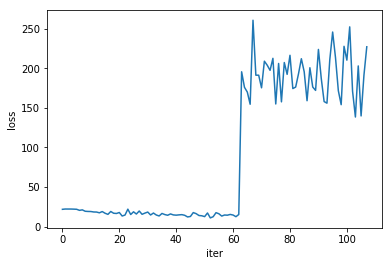

In [9]:
plt.plot(losses)
plt.xlabel("iter")
plt.ylabel("loss")
fig_size = plt.rcParams["figure.figsize"]
print("Current size:", fig_size)
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
plt.show()

**Evaluate performance**

In [28]:
def makePosList(h_pred, l_pred):
    p2d_y, p2d_x = np.unravel_index(torch.argmax(h_pred.view(num_joints, -1), dim=1).data.numpy(), (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    p3d_x = l_pred[0].data.numpy()
    p3d_x = p3d_x[p2d_y, p2d_x]

    p3d_y = l_pred[1].data.numpy()
    p3d_y = p3d_y[p2d_y, p2d_x]

    p3d_z = l_pred[2].data.numpy()
    p3d_z = p3d_z[p2d_y, p2d_x]

    p3d = np.stack((p3d_x, p3d_y, p3d_z), axis=-1)
    
    return p2d, p3d
#b_idx = torch.from_numpy(np.repeat(np.arange(batch_size), num_joints)).long()
mplb_idx = np.repeat(np.arange(batch_size), num_joints)
def makePosListBatch(h_pred, l_pred):
    idx_2d = torch.argmax(h_pred.view(batch_size, num_joints, -1), dim=2).data.numpy()
    
    p2d_y, p2d_x = np.unravel_index(idx_2d, (image_size, image_size))
    p2d = np.stack((p2d_x, p2d_y), axis=-1)

    l_pred = l_pred.view(batch_size, 3, -1)
    
    p3d_x = l_pred[:, 0].data.numpy()
    p3d_x = p3d_x[mplb_idx, idx_2d.reshape(-1)]

    p3d_y = l_pred[:, 1].data.numpy()
    p3d_y = p3d_y[mplb_idx, idx_2d.reshape(-1)]

    p3d_z = l_pred[:, 2].data.numpy()
    p3d_z = p3d_z[mplb_idx, idx_2d.reshape(-1)]

    p3d = np.stack((p3d_x.reshape(batch_size, num_joints), p3d_y.reshape(batch_size, num_joints), p3d_z.reshape(batch_size, num_joints)), axis=-1)
    
    return p2d, p3d

print("Evaluation...")
eval_loss = 0
eval_iter = 0
def eval_net():
    for idx, batch in enumerate(loader_train):
        eval_iter = idx
        image = batch['image'].float()
        pos2d_list = batch['pos_2d'] # size (N, 21, 2)
        pos3d_list = batch['pos_3d'] # size (N, 21, 3)
        loc_map, heatmap, one_hot = makeMaps(pos2d_list, pos3d_list)
        y_pred = model(image)
        h_pred = modelHeatmap(y_pred)
        l_pred = modelLocmap(y_pred)
        #print("output shape: {}".format(y_pred.shape))
        # use heatmap loss defined in VNect
        #loss = computeLoss(heatmap, one_hot, loc_map, h_pred, l_pred)

        #eval_loss = eval_loss + loss

        if idx == 0:
            # show some images
            p2d, p3d = makePosList(h_pred[0], l_pred[0])
            show_joints(image[0].data.numpy().transpose((1,2,0)), p2d, p3d)
            show_joints(image[0].data.numpy().transpose((1,2,0)), batch['pos_2d'][0], batch['pos_3d'][0])
            break
#eval_net()
#eval_iter = eval_iter + 1
#print("Eval Loss: {}".format(eval_loss / eval_iter))

Evaluation...


**Fully Connected Layer to Predict Gesture**

Input: The outputs of our joint prediction model outputs:

    p2d: # size (N, 21, 2)
    p3d: # size (N, 21, 3)
    
Output: 

    y: # size (N, C=10), where C is the number of gesture classes

**Note**: We will use both the 2D positions and the 3D positions of the joints to figure out what the gesture is

In [9]:
# First, let's get the gesture data
g_dataset = GestureDataset('gesture_dataset.csv', transform=transform, train=True)

N = len(g_dataset)

loader_g_train = DataLoader(g_dataset, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8))))

loader_g_val = DataLoader(g_dataset, batch_size=batch_size,
            sampler=sampler.SubsetRandomSampler(range(int(N*0.8), int(N*0.9))))

loader_g_test = DataLoader(g_dataset, batch_size=batch_size,
                         sampler=sampler.SubsetRandomSampler(range(int(N*0.9),N)))

**Define the Model**

In [10]:
# our fc should just output probabilities
fc = nn.Sequential(
    nn.Linear(in_features=105, out_features=105),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=105, out_features=50),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(in_features=50, out_features=10),
    nn.Softmax(dim=1)
)

# predicted gesture probability distribution

** Define the FC loss function**

In [30]:
# Defines constants
batch_idx = torch.from_numpy(np.arange(batch_size)).long()

def compute_g_loss(p2d, p3d, g_GT):
    p2d = torch.from_numpy(p2d)
    p3d = torch.from_numpy(p3d)

    # put 2D and 3D joint positions together
    fc_in = torch.cat((p2d.float(), p3d), dim=2) # shape (N, 21, 5)
    fc_in = fc_in.view(batch_size, -1) # shape(N, 105)

    # g_GT is of size (N, ) it just contains the labels for the batch
    g_pred = fc(fc_in) # shape (N, 10) 
    g_loss = torch.sum(-1.0 * (g_pred[batch_idx, g_GT.long()] + epsilon).log()) / batch_size
    return g_loss

**Freeze Joint Prediction Network and Define Optimizer**

In [13]:
# completely free out JP Net
for param in model.parameters():
    param.requires_grad = False
for param in modelHeatmap.parameters():
    param.requires_grad = False
for param in modelLocmap.parameters():
    param.requires_grad = False

# Optimize fully connected network only
g_optimizer = torch.optim.Adam(fc.parameters(), lr=1.0e-4)
g_losses = []

**Training Loop**

In [31]:
for epoch in range(50):
    print("Epoch: {}".format(epoch))
    for idx, batch in enumerate(loader_g_train):
        # make all the ground truth tensors needed for loss computation
        image = batch['image'].float()
        # y_pred is of size 64 x 224 x 224
        y_pred = model(image)
        
        # h_pred is of size 21 x 224 x 224
        h_pred = modelHeatmap(y_pred)
        
        # l_pred is of size 3 x 224 x 224, the 3 representing x, y, z location maps of all 21 joints
        l_pred = modelLocmap(y_pred)
        
        p2d, p3d = makePosListBatch(h_pred, l_pred)
        print(p2d.shape, p3d.shape)
        # print and store the loss curve
        
        g_loss = compute_g_loss(p2d, p3d, batch['label'])
        
        print("G Loss: {}".format(g_loss))
        g_losses.append(g_loss)
        
        g_loss.backward()
        
        g_optimizer.step()
        # Clears the gradients of all optimized torch.Tensor s
        g_optimizer.zero_grad()
        
    torch.save(fc.state_dict(), 'fc_param.pt')
    torch.save(g_optimizer.state_dict(), 'g_optimizer_param.pt')
    torch.save({'losses': g_losses, 'epoch': epoch + 1}, 'g_training_param.pt')
        
print("======Training Done======")

Epoch: 0
(4, 21, 2) (4, 21, 3)
G Loss: 8.036097526550293
(4, 21, 2) (4, 21, 3)
G Loss: 11.19482421875
(4, 21, 2) (4, 21, 3)
G Loss: 13.355612754821777
(4, 21, 2) (4, 21, 3)
G Loss: 16.80914878845215
(4, 21, 2) (4, 21, 3)
G Loss: 12.996598243713379
(4, 21, 2) (4, 21, 3)
G Loss: 14.209319114685059
(4, 21, 2) (4, 21, 3)
G Loss: 8.795677185058594
(4, 21, 2) (4, 21, 3)
G Loss: 16.207300186157227
(4, 21, 2) (4, 21, 3)
G Loss: 14.637527465820312
(4, 21, 2) (4, 21, 3)
G Loss: 7.711728572845459
(4, 21, 2) (4, 21, 3)
G Loss: 14.034470558166504
(4, 21, 2) (4, 21, 3)
G Loss: 12.32028865814209


KeyboardInterrupt: 